# PID Graph for FREYA-funded publications

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all publications with a DataCite DOI funded by the FREYA grant.

In [18]:
# Prepare the R graphql client.

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

In [19]:
query <- '{
  publications(query: "fundingReferences.awardNumber:777523") {
    totalCount
    nodes {
      id
      creators {
        id
      }
      relatedIdentifiers {
        relatedIdentifier
      }
      fundingReferences {
        funderIdentifier
      }
    }
  }
  datasets(query: "fundingReferences.awardNumber:777523") {
    totalCount
    nodes {
      id
      creators {
        id
      }
      relatedIdentifiers {
        relatedIdentifier
      }
      fundingReferences {
        funderIdentifier
      }
    }
  }
}'

In [20]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [21]:
# Get the number of publications and datasets

display_json(data$data$publications$totalCount)
display_json(data$data$datasets$totalCount)

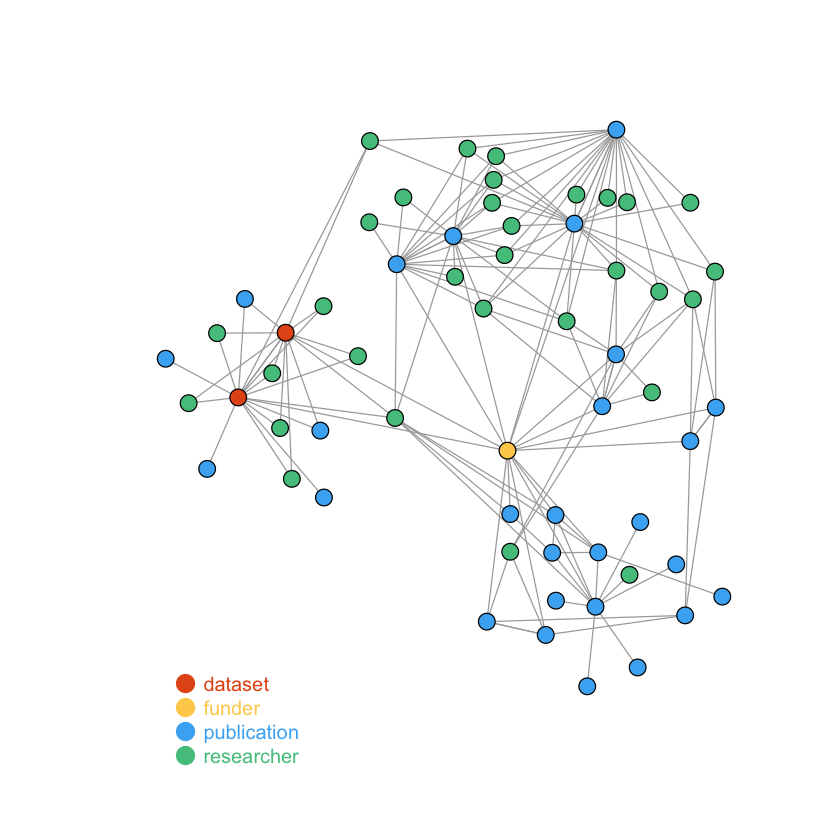

In [22]:
# generate data frame for nodes
publications <- data.frame(id=data$data$publications$nodes$id, pid_type=c('publication'))
datasets <- data.frame(id=data$data$datasets$nodes$id, pid_type=c('dataset'))
researchers <- data.frame(id=bind_rows(data$data$publications$nodes$creators)[,1], pid_type=c('researcher'))
researchers <- researchers %>% filter(!is.na(as.character(id)))
dataset_researchers <- data.frame(id=bind_rows(data$data$datasets$nodes$creators)[,1], pid_type=c('researcher'))
dataset_researchers <- dataset_researchers %>% filter(!is.na(as.character(id)))
references <- data.frame(id=bind_rows(data$data$publications$nodes$relatedIdentifiers)[,1], pid_type=c('publication'))
references <- references %>% filter(!is.na(as.character(id))) %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
dataset_references <- data.frame(id=bind_rows(data$data$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('publication'))
dataset_references <- dataset_references %>% filter(!is.na(as.character(id))) %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
funders <- data.frame(id=bind_rows(data$data$publications$nodes$fundingReferences)[,1], pid_type=c('funder'))
datset_funders <- data.frame(id=bind_rows(data$data$datasets$nodes$fundingReferences)[,1], pid_type=c('funder'))
nodes <- rbind(publications, datasets, researchers, dataset_researchers, references, dataset_references, funders, datset_funders)

# remove duplicates
nodes <- nodes %>% distinct(id, .keep_all = TRUE)

# loop through nodes, as they can have more than one edge
edges <- data.frame(to=character(), from=character())
nodes_with_creators <- bind_rows(data$data$publications$nodes) %>% filter(lengths(creators) != 0)
for (i in 1:nrow(nodes_with_creators)) {
  row <- data.frame(to=unlist(nodes_with_creators[i,2]), from=nodes_with_creators[i,1])
  edges <- unique(rbind(edges, row))
}
dataset_nodes_with_creators <- bind_rows(data$data$datasets$nodes) %>% filter(lengths(creators) != 0)
for (i in 1:nrow(dataset_nodes_with_creators)) {
  row <- data.frame(to=unlist(dataset_nodes_with_creators[i,2]), from=dataset_nodes_with_creators[i,1])
  edges <- unique(rbind(edges, row))
}

nodes_with_references <- bind_rows(data$data$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
for (i in 1:nrow(nodes_with_references)) {
  row <- data.frame(to=unlist(nodes_with_references[i,3]), from=nodes_with_references[i,1])
  edges <- unique(rbind(edges, row))
}
dataset_nodes_with_references <- bind_rows(data$data$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
for (i in 1:nrow(dataset_nodes_with_references)) {
  row <- data.frame(to=unlist(dataset_nodes_with_references[i,3]), from=dataset_nodes_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

nodes_with_dataset_references <- bind_rows(data$data$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
for (i in 1:nrow(nodes_with_dataset_references)) {
  row <- data.frame(to=unlist(nodes_with_dataset_references[i,3]), from=nodes_with_dataset_references[i,1])
  edges <- unique(rbind(edges, row))
}

nodes_with_funding <- bind_rows(data$data$publications$nodes) %>% filter(lengths(fundingReferences) != 0)
for (i in 1:nrow(nodes_with_funding)) {
  row <- data.frame(to=unlist(nodes_with_funding[i,4]), from=nodes_with_funding[i,1])
  edges <- unique(rbind(edges, row))
}
dataset_nodes_with_funding <- bind_rows(data$data$datasets$nodes) %>% filter(lengths(fundingReferences) != 0)
for (i in 1:nrow(dataset_nodes_with_funding)) {
  row <- data.frame(to=unlist(dataset_nodes_with_funding[i,4]), from=dataset_nodes_with_funding[i,1])
  edges <- unique(rbind(edges, row))
}

# express DOIs as URLs
edges <- edges %>% filter(!is.na(as.character(to))) %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

g <- graph_from_data_frame(d=edges, vertices=nodes)

# Node colors
col = c('#e45718','#fecf59','#48b1f4','#53c48c')
V(g)[(V(g)$pid_type=="publication")]$color<-'#48b1f4'
V(g)[(V(g)$pid_type=="researcher")]$color<-'#53c48c'
V(g)[(V(g)$pid_type=="funder")]$color<-'#fecf59'
V(g)[(V(g)$pid_type=="dataset")]$color<-'#e45718'

# add labels to selected nodes
V(g)$label=NA
#V(g)[(V(g)$id=="https://doi.org/10.5281/zenodo.1202173")]$label<-"B"
#V(g)[(V(g)$pid_type=="funder")]$label <- "A"
#V(g)[(V(g)$pid_type=="funder")]$label.dist <- 1

V(g)$size <- 6
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)
plot(g, layout=l, arrow.mode=0)

# Add a legend
legend("bottomleft", legend=levels(as.factor(V(g)$pid_type)), col = col, bty = "n", pch=20 , pt.cex = 3, cex = 1, text.col=col , horiz = FALSE, inset = c(0.1, -0.1))

In [23]:
# Generate a list of formatted citations in APA format for the publications

ids <- substring(publications[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publications')
display_markdown(content(response, as = 'text'))

## Publications

Braukmann, R., Fankhauser, E., Jong, M. D., Horik, R. V., Lemon, B., Ferguson, C., … Dallmeier-Tiessen, S. (2018). Deliverable 5.3 First Report on the PID Forum. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.2414527

Braukmann, R., Fankhauser, E., Jong, M. D., Horik, R. V., Lemon, B., Ferguson, C., … Dallmeier-Tiessen, S. (2018). Deliverable 5.3 First Report on the PID Forum. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.2414526

Lavasa, A., Dallmeier-Tiessen, S., Sandt, S. V. D., Tsanaktsidis, I., Trzcinska, A., Fokianos, P., … Jong, M. D. (2018). Deliverable 4.1 Integration of Mature PID Types. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.2414839

Lavasa, A., Dallmeier-Tiessen, S., Sandt, S. V. D., Tsanaktsidis, I., Trzcinska, A., Fokianos, P., … Jong, M. D. (2018). Deliverable 4.1 Integration of Mature PID Types. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.2414838

Simons, N., Brown, C., &amp; Braukmann, R. (2019). Adventure Time: the PID community challenge - Presentation at PIDapalooza19. https://doi.org/10.5281/ZENODO.2548715

Simons, N., Brown, C., &amp; Braukmann, R. (2019). Adventure Time: the PID community challenge - Presentation at PIDapalooza19. https://doi.org/10.5281/ZENODO.2548714

Baars, C., &amp; De Jong, M. (2019). NARCIS &amp; FREYA  Can PIDs contribute to research in context? https://doi.org/10.5281/ZENODO.2552138

Baars, C., &amp; De Jong, M. (2019). NARCIS &amp; FREYA  Can PIDs contribute to research in context? https://doi.org/10.5281/ZENODO.2552137

Fenner, M., &amp; Aryani, A. (2019). Introducing the PID Graph (Version 1.0). https://doi.org/10.5438/JWVF-8A66

Fenner, M. (2019). Exposing DOI metadata provenance (Version 1.0). https://doi.org/10.5438/WY92-XJ57

Ferguson, C., McEntyre, J., Hendricks, G., Dohna, T., Koop-Jakobsen, K., Madden, F., … Fenner, M. (2019). <i>Deliverable D3.2 Requirements for Selected New PID Services</i>. Zenodo. https://doi.org/10.5281/ZENODO.2649230

Ferguson, C., McEntyre, J., Hendricks, G., Dohna, T., Koop-Jakobsen, K., Madden, F., … Fenner, M. (2019). <i>Deliverable D3.2 Requirements for Selected New PID Services</i>. Zenodo. https://doi.org/10.5281/ZENODO.2649229

Fenner, M. (2019). The DataCite GraphQL API is now open for (pre-release) business (Version 1.0). https://doi.org/10.5438/QAB1-N315

Fenner, M. (2019). Using Jupyter Notebooks with GraphQL and the PID Graph (Version 1.0). https://doi.org/10.5438/HWAW-XE52

In [24]:
# Generate a list of formatted citations in APA format for the datasets

ids <- substring(datasets[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Datasets')
display_markdown(content(response, as = 'text'))

## Datasets

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202173

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., … Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1263942